# Signals

In [1]:
%%writefile signalform.py

import numpy as np
from numpy import pi, cos, sin


class SignalForm:
    """ Generate the Signal Form
    
        SignalForm Name : [parameters], Outpux Form
        `'Sine'`        
            [A, f_0, phi_0]            
            Output: A * \sin(2 * π * f_0 * t + \phi_0)
        `'Line-chirp'`
            [A, f_0, f_1, phi_0]          
            Output: A * \sin(2 * π * (f_0 + f_1 * t) * t + \phi_0)
        `'Quad-chirp'`  
            [A, f_0, f_1, f_2, phi_0]     
            Output: A * \sin(2 * π * (f_0 + f_1 * t + f_2 * t**2) * t + \phi_0)
        `'Sine-gauss'`  
            [A, t_0, sigma, f_0, phi_0]   
            Output: A * exp(- (t-t_0)**2 / (2 * sigma**2)) \sin(2 * π * f_0 * t + \phi_0)
        `'FM-sine'`    
            [A, b, f_0, f_1]              
            Output: A * \sin(2 * π * f_0 * t + b \cos(2 * π * f_1 * t))
        `'AM-sine'`    
            [A, f_0, f_1, phi_0]          
            Output: A * \cos(2 * π * f_1 * t) * \sin(2 * π * f_0 * t + \phi_0)
        `'AM-FM-sine'`  
            [A, b, f_0, f_1]              
            Output: A * \cos(2 * π * f_1 * t) * \sin(2 * π * f_0 * t + b \cos(2 * π * f_1 * t))
        `'LT-chirp'`    
            [A, t_a, f_0, f_1, phi_0, L]  
            Output: A * \sin(2 * π * (f_0 * (t - t_a) + f_1 * (t - t_a)**2) + \phi_0) When t in [t_a, t_a + L]
                  : 0    When t not in [t_a, t_a + L]
    """
    def __init__(self, signal=None, **params):
        
        self._dict = {
            'Sine': self._sine,
            'Line-chirp': self._linearChirp,
            'Quad-chirp': self._QuadraticChirp,
            'Sine-gauss': self._sineGauss,
            'FM-sine': self._FMSine,
            'AM-sine': self._AMSine,
            'AM-FM-sine': self._AM_FMSine,
            'LT-chirp': self._LinearTransientChirp
        }
        self.signals = self._dict.keys()
        
        if signal is None:
            raise Exception("No Signal specified.")
        else:
            self._signal = signal           
            self._dict[signal](**params)
        
    def __call__(self, x):
        x = np.asarray(x)
        return self.eval(x)
    
    def _sine(self, A, f_0, phi_0):
        def ans(x):
            phase = 2 * pi * f_0 * x + phi_0
            sig = sin(phase)
            return A * sig / np.linalg.norm(sig)
        
        self.eval = ans

    def _linearChirp(self, A, f_0, f_1, phi_0):
        def ans(x):
            phase = 2 * pi * (f_0 + f_1 * x) * x + phi_0
            sig = sin(phase)
            return A * sig / np.linalg.norm(sig)
        
        self.eval = ans
    
    def _QuadraticChirp(self, A, f_0, f_1, f_2, phi_0):
        def ans(x):
            phase = 2 * pi * (f_0 + f_1 * x + f_2 * x * x) * x + phi_0
            sig = sin(phase)
            return A * sig / np.linalg.norm(sig)
        
        self.eval = ans
    
    def _sineGauss(self, A, t_0, sigma, f_0, phi_0):  
        def ans(x):
            phase = 2 * pi * f_0 * x + phi_0
            sig = np.exp(-(x - t_0)**2 / (2 * sigma**2)) * sin(phase)
            return A * sig / np.linalg.norm(sig)
        self.eval = ans
        
    def _FMSine(self, A, b, f_0, f_1):
        def ans(x):
            phase = 2 * pi *  f_0 * x + b * cos(2 * pi * f_1 * x)
            sig = sin(phase)
            return A * sig / np.linalg.norm(sig)
        self.eval = ans
    
    def _AMSine(self, A, f_0, f_1, phi_0):
        def ans(x):
            phase = 2 * pi * f_0 * x + phi_0
            sig = cos(2 * pi * f_1 * x) * sin(phase)
            return A * sig / np.linalg.norm(sig)
        self.eval = ans
    
    def _AM_FMSine(self, A, b, f_0, f_1):
        def ans(x):
            phase = 2 * pi *  f_0 * x + b * cos(2 * pi * f_1 * x)
            sig = cos(2 * pi * f_1 * x) * sin(phase)
            return A * sig / np.linalg.norm(sig)
        self.eval = ans
    
    def _LinearTransientChirp(self, A, t_a, f_0, f_1, phi_0, L):
        def ans(x):
            tmp = lambda tt: f_0 * (tt - t_a) + f_1 * (tt - t_a)**2
            ltc = lambda t: sin(2 * pi * tmp(t) + phi_0)
            sig = np.asarray([ltc(xx) if xx >= t_a and xx <= (t_a + L) else 0 for xx in x])
            return A * sig / np.linalg.norm(sig)
        self.eval = ans

Overwriting signalform.py


In [2]:
from math import floor
from scipy.fftpack import fft
import matplotlib.pyplot as plt

def test_signal(timeVec, sigVec, title='', figsize=(9, 5)):
    # Length of data
    nSamples = len(timeVec)
    timeLen = timeVec[-1] - timeVec[0]
    # DFT sample corresponding to Nyquist frequency
    Nyq = floor(nSamples / 2) + 1
    # Positive Fourier frequencies
    posFreq = np.arange(Nyq) / timeLen
    # FFT of signal
    fftSig = fft(sigVec)
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    ax = axs[0]
    ax.plot(timeVec, sigVec)
    ax.set_title('Time-domain Diagram')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('s(t)')

    ax = axs[1]
    ax.errorbar(posFreq, np.abs(fft(sigVec)[0:Nyq]))
    ax.set_title('Frequency-domain Diagram')
    ax.set_xlabel('frequency (Hz)')
    ax.set_ylabel(r'$\tilde{s}(f)$')

    fig.suptitle(title)
    plt.show()

## Test for Sine Signal

<IPython.core.display.Javascript object>


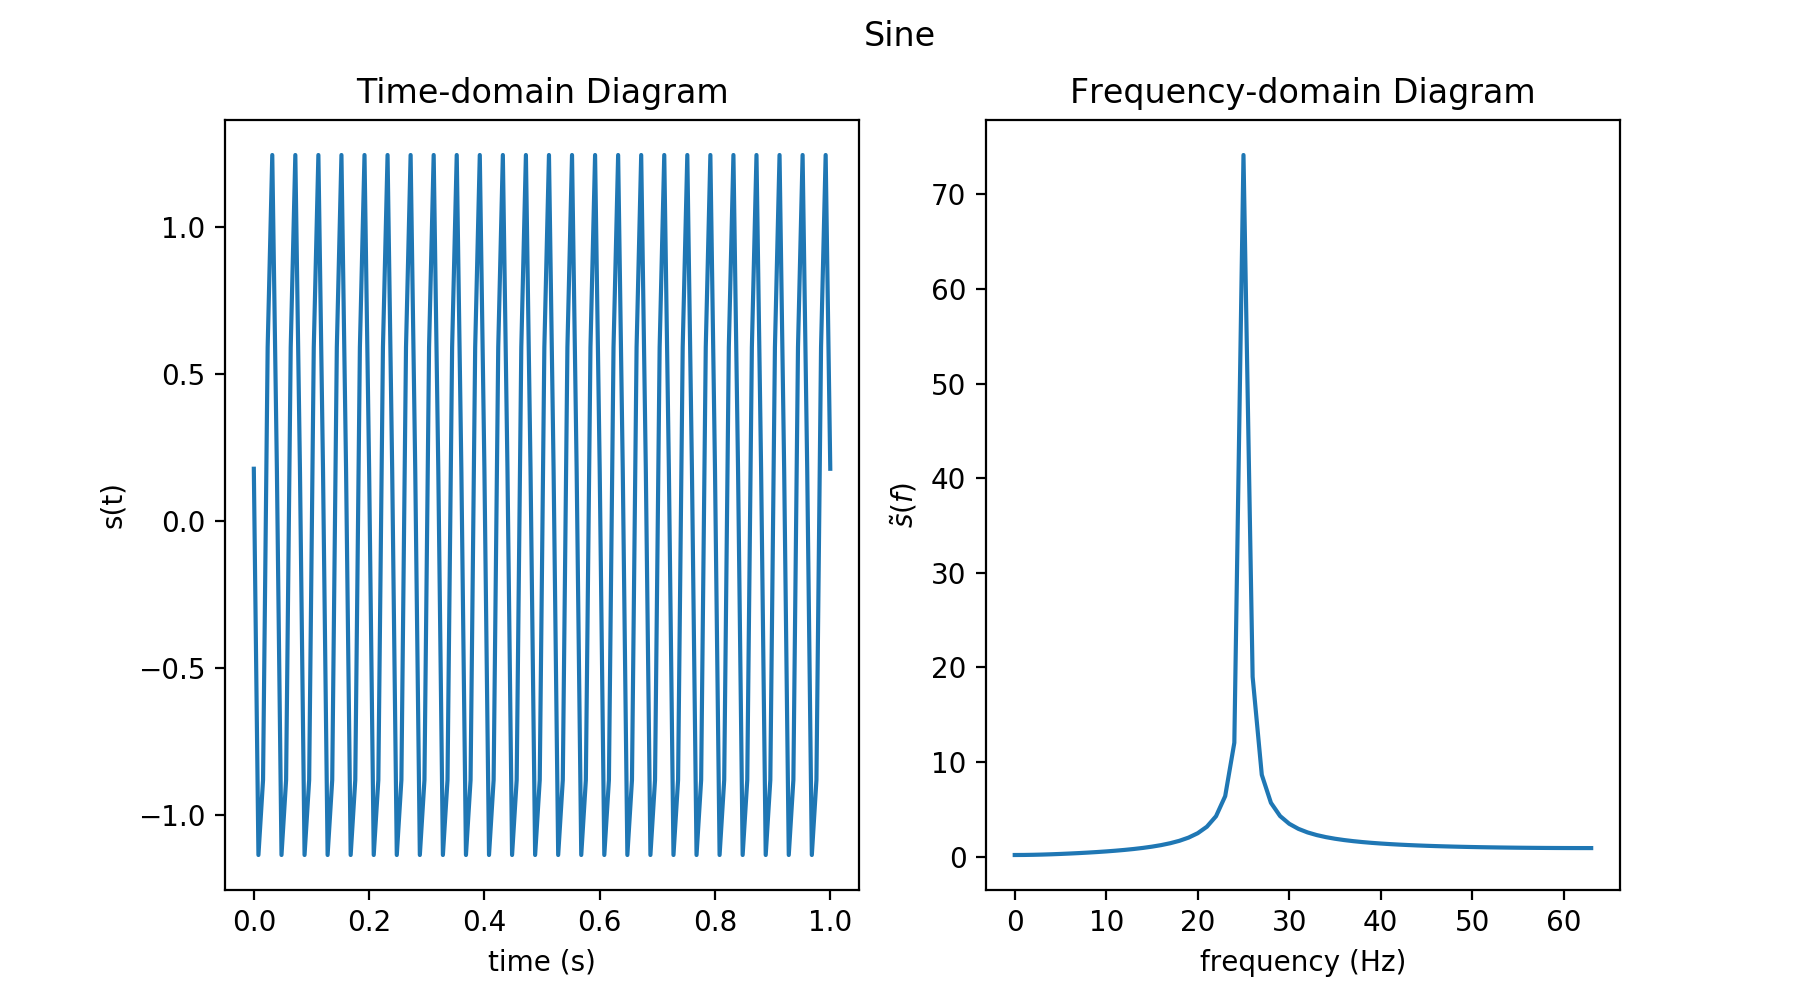

In [3]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

import numpy as np
from signalform import SignalForm


Freq = 25
samplFreq = 5*Freq

samplIntrvl = 1/samplFreq

timeVec = np.linspace(0.0, 1.0, samplFreq+1)

sinSignal = SignalForm(signal='Sine', A=10, f_0=Freq, phi_0=3)

sigVec = sinSignal(timeVec)
test_signal(timeVec, sigVec, title='Sine')

## Test for Linear Chirp Signal

<IPython.core.display.Javascript object>


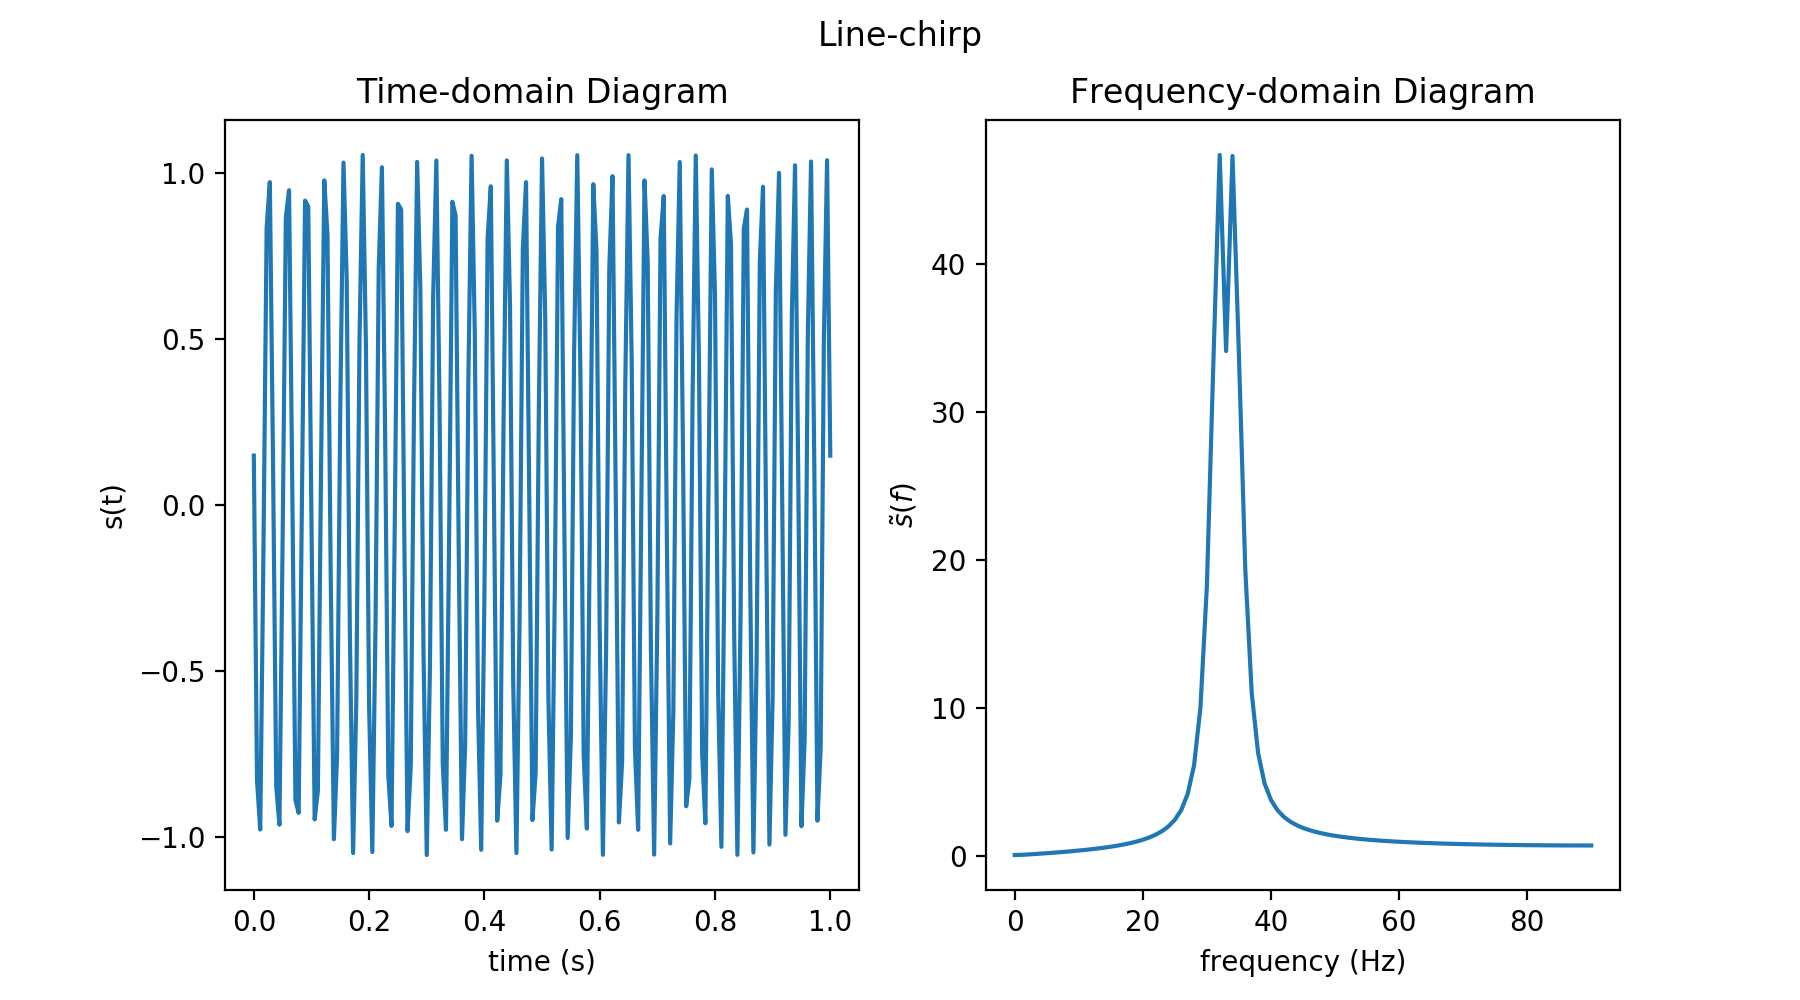

In [4]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

import numpy as np
from signalform import SignalForm

A, f_0, f_1, phi_0 = 10, 30, 3, 3

maxFreq = f_0 + 2 * f_1
samplFreq = 5*maxFreq

samplIntrvl = 1/samplFreq

timeVec = np.linspace(0.0, 1.0, samplFreq+1)

sinSignal = SignalForm(signal='Line-chirp', A=A, f_0=f_0, f_1=f_1, phi_0=phi_0)

sigVec = sinSignal(timeVec)
test_signal(timeVec, sigVec, title='Line-chirp')

## Test for Sine-Gaussian Signal

<IPython.core.display.Javascript object>


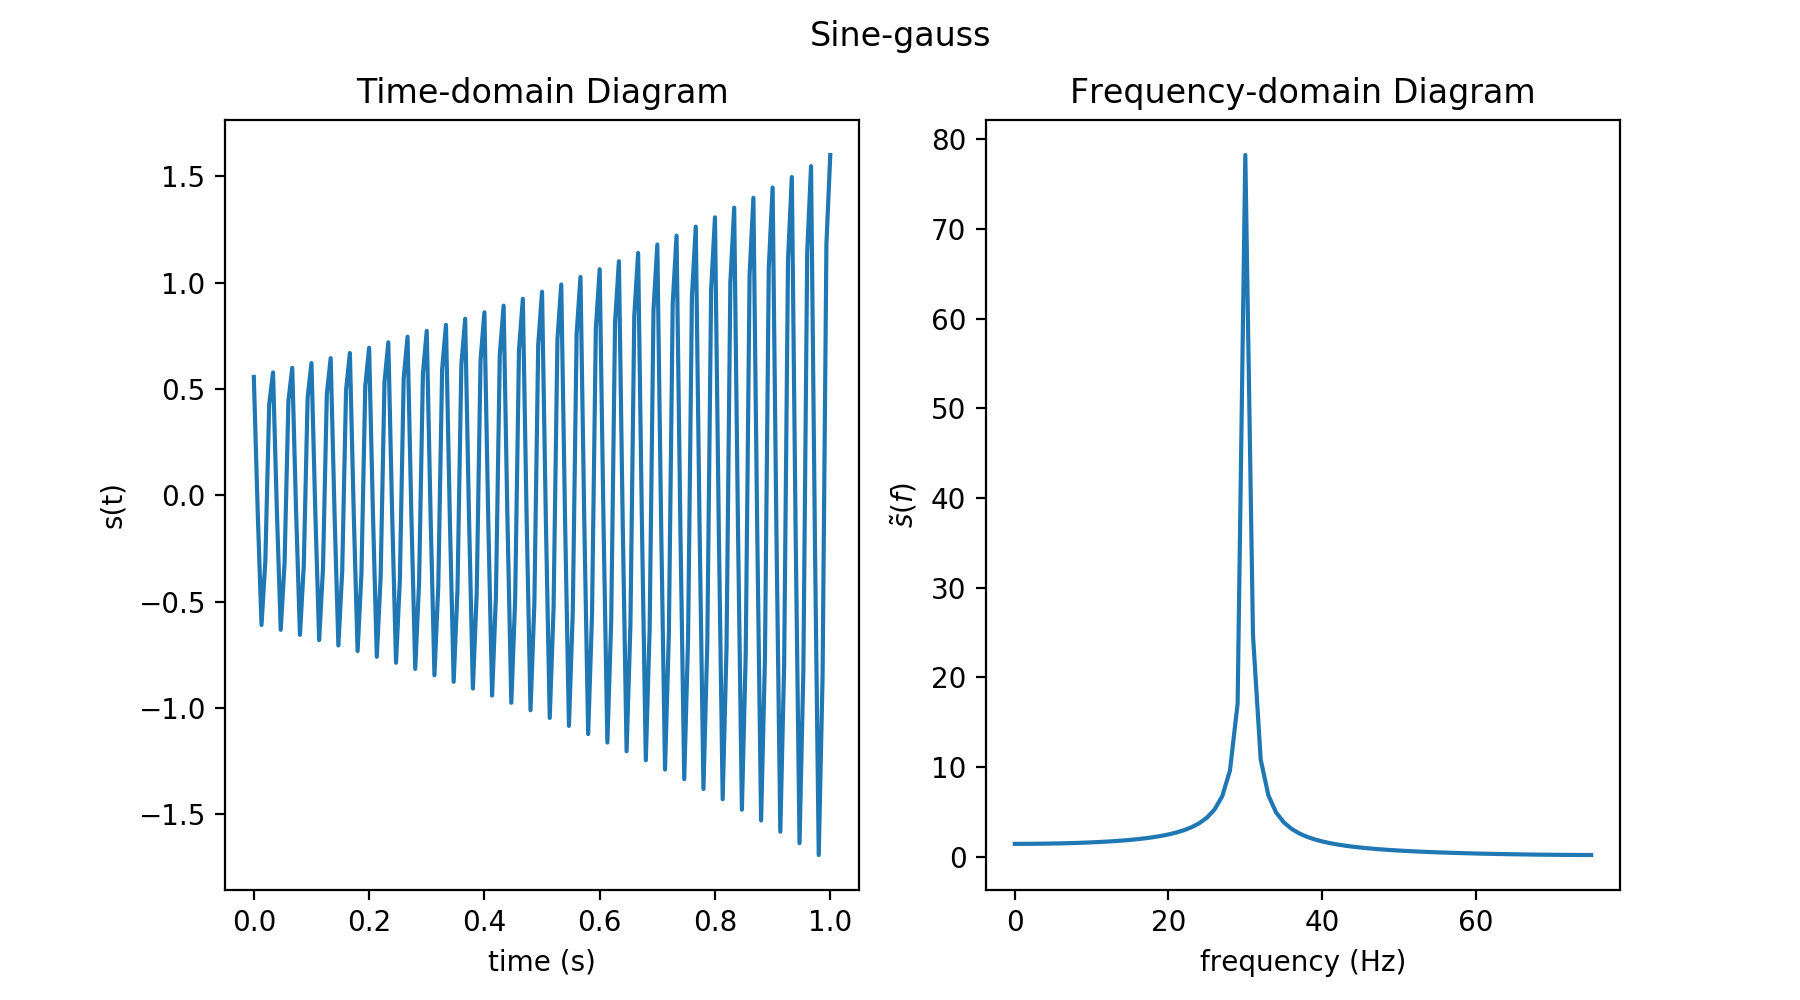

In [5]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

import numpy as np
from signalform import SignalForm


Freq = 30
samplFreq = 5*Freq

samplIntrvl = 1/samplFreq

timeVec = np.linspace(0.0, 1.0, samplFreq+1)

sinSignal = SignalForm(signal='Sine-gauss', A=10, t_0=10, sigma=3, f_0=Freq, phi_0=2)

sigVec = sinSignal(timeVec)
test_signal(timeVec, sigVec, title='Sine-gauss')